# ***1. Data Pre-processing***

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

from table_evaluator import load_data, TableEvaluator
from sklearn.impute import SimpleImputer
import warnings


C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\table_evaluator\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


IPython not installed.


In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)
# ==============================================================================
# SECTION 1: DATA PRE-PROCESSING AND SCALING
# ==============================================================================
# --- Step 1: Data Pre-processing ---

df = pd.read_csv('VirtualPatientModels_dfFinal_qDate.csv')

# Store the original column order and a copy of the q_date column
original_cols_order = df.columns.tolist()
original_q_date_full = pd.to_datetime(df['q_date'].copy())

df['q_date'] = pd.to_datetime(df['q_date'])
df = df.sort_values(by=['part_id', 'q_date'])
df['time_delta_days'] = df.groupby('part_id')['q_date'].diff().dt.days.fillna(0).astype(int)

numerical_cols = ['bmi_score', 'gait_get_up', 'bmi_body_fat', 'raise_chair_time', 'waist', 'time_delta_days']
categorical_cols = ['age', 'hospitalization_three_years', 'stairs_number', 'comorbidities_significant_count',
                    'social_text', 'alcohol_units', 'ortho_hypotension', 'balance_single',
                    'gait_optional_binary', 'depression_total_score', 'social_calls',
                    'comorbidities_most_important', 'iadl_grade', 'house_suitable_professional',
                    'comorbidities_count', 'leisure_out', 'gender', 'house_suitable_participant',
                    'memory_complain', 'living_alone', 'health_rate', 'weight_loss',
                    'low_physical_activity', 'social_phone', 'life_quality',
                    'health_rate_comparison', 'sleep']

# Store original categorical values and perform one-hot encoding with integer values
one_hot_map = {}
for col in categorical_cols:
    df[col] = df[col].astype('category')
    one_hot_map[col] = list(df[col].cat.categories)

df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dtype=np.int8)

# Drop columns that are not features for the model input
df_encoded = df_encoded.drop(columns=['q_date', 'clinical_visit'])

# The list of columns for training must not include `part_id`
columns_for_training = df_encoded.drop(columns='part_id').columns

scaler = MinMaxScaler()
scaler.fit(df_encoded.drop(columns='part_id')[columns_for_training])
df_encoded[columns_for_training] = scaler.transform(df_encoded.drop(columns='part_id')[columns_for_training])

# ***2. Time-GAN Model Setup and Training to generate Synthetic data***

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)
# --- Step 2: Time-GAN Model Setup and Training ---

gan_args = ModelParameters(
    batch_size=128,
    lr=5e-4,
    noise_dim=64,
    layers_dim=256,
    latent_dim=32,
    gamma=1
)

max_seq_len = max(len(group) for _, group in df.groupby('part_id'))
num_features = len(columns_for_training)

train_args = TrainParameters(
    epochs=2000,
    sequence_length=max_seq_len,
    number_sequences=num_features
)

synth = TimeSeriesSynthesizer(modelname='timegan', model_parameters=gan_args)
synth.fit(df_encoded.drop(columns='part_id'), train_args, num_cols=columns_for_training.to_list())

# ---  Generating Synthetic Data ---
synth_data = synth.sample(n_samples=3783)

A DataProcessor is not available for the TimeGAN.



Joint networks training: 100%|██████████| 2000/2000 [32:10<00:00,  1.04it/s] 


# ***3. Post-processing and Reverting the Scaling/Encoding to final synthetic dataframe***

In [4]:
# --- Step 3: Post-processing and Reverting the Scaling/Encoding ---
synth_data_np = np.array(synth_data)
synth_data_flat = synth_data_np.reshape(-1, num_features)
synth_data_rescaled = scaler.inverse_transform(synth_data_flat)
synth_data_rescaled = synth_data_rescaled.reshape(-1, max_seq_len, num_features)

synth_df_list = []
synthetic_part_id_counter = 3000

# Get a list of unique starting dates from the original data
unique_start_dates = df.groupby('part_id')['q_date'].min().tolist()

for i in range(synth_data_rescaled.shape[0]):
    # Use the correct columns_for_training list here
    temp_df = pd.DataFrame(synth_data_rescaled[i], columns=columns_for_training)

    temp_df_reverted = pd.DataFrame()

    for col_prefix in categorical_cols:
        cols_to_combine = [c for c in temp_df.columns if c.startswith(col_prefix)]
        if cols_to_combine:
            reverted_col_indices = np.argmax(temp_df[cols_to_combine].values, axis=1)
            reverted_col_indices = np.clip(reverted_col_indices, 0, len(one_hot_map[col_prefix]) - 1)
            reverted_col = [one_hot_map[col_prefix][idx] for idx in reverted_col_indices]
            temp_df_reverted[col_prefix] = reverted_col
            
    for col in numerical_cols:
        temp_df_reverted[col] = temp_df[col]
    
    # DYNAMICALLY GENERATE q_date FOR EACH SYNTHETIC PATIENT 
    if not unique_start_dates:
        # Fallback if the original data has no unique start dates
        start_date = pd.to_datetime('2016-01-01')
    else:
        # Select a random start date from the original data's unique start dates
        start_date = pd.to_datetime(np.random.choice(unique_start_dates))
    
    dates = [start_date]
    for _ in range(1, len(temp_df_reverted)):
        # Generate a random time delta between 6 and 9 months
        time_delta_days = np.random.randint(182, 274)
        next_date = dates[-1] + pd.Timedelta(days=time_delta_days)
        dates.append(next_date)
    
    temp_df_reverted['q_date'] = dates
    
    temp_df_reverted['clinical_visit'] = range(1, len(temp_df_reverted) + 1)
    temp_df_reverted['part_id'] = synthetic_part_id_counter
    
    synth_df_list.append(temp_df_reverted)
    synthetic_part_id_counter += 1

final_synthetic_data = pd.concat(synth_df_list, ignore_index=True)

# Final step: Post-processing and column reordering
final_synthetic_data = final_synthetic_data.reindex(columns=original_cols_order)

# Correct data types
for col in final_synthetic_data.columns:
    if col in categorical_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            final_synthetic_data[col] = pd.to_numeric(final_synthetic_data[col], errors='coerce').round(0).astype('Int64')
        else:
            final_synthetic_data[col] = final_synthetic_data[col].astype('category')
    elif col in numerical_cols:
        final_synthetic_data[col] = pd.to_numeric(final_synthetic_data[col], errors='coerce')
        
#print("Example of formatted synthetic data:")
#print(final_synthetic_data.head(10).to_string())
#print(final_synthetic_data.info())

print("\n" + "="*80)
print("IMBALANCED SYNTHETIC DATA GENERATION COMPLETE")
print(final_synthetic_data.value_counts())
print("New Synthetic Health Rate Distribution:")
print(final_synthetic_data['health_rate'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print(final_synthetic_data['health_rate'].value_counts())


IMBALANCED SYNTHETIC DATA GENERATION COMPLETE
part_id  clinical_visit  bmi_score  gait_get_up  bmi_body_fat  raise_chair_time  waist       leisure_out  balance_single       stairs_number  gender  sleep                     house_suitable_professional  alcohol_units  comorbidities_most_important                   memory_complain  house_suitable_participant  social_calls  comorbidities_significant_count  depression_total_score  weight_loss  gait_optional_binary  hospitalization_three_years  iadl_grade  living_alone  life_quality  age  social_phone  health_rate    q_date                     comorbidities_count  low_physical_activity  health_rate_comparison  social_text  ortho_hypotension
3000     1               42.939999  18.610046    35.598621     280.600708        123.569824  7            test non realizable  2.0            F       Occasional sleep problem  Yes                          0.0            Osteoporosis if woman  /Osteoarthritis if man  No               Yes                   

## 3.1 Final dataframe to csv file 

In [5]:
final_synthetic_data.to_csv("VirtualPatientModels_timeGANsynthData_Final_Imbalance_Dis.csv", index=False)

# ***4. Evaluation of Samples***

C:\Users\paulo\AppData\Local\Temp\ipykernel_49084\4258037173.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eval[col].fillna(mode_value_df, inplace=True)
C:\Users\paulo\AppData\Local\Temp\ipykernel_49084\4258037173.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

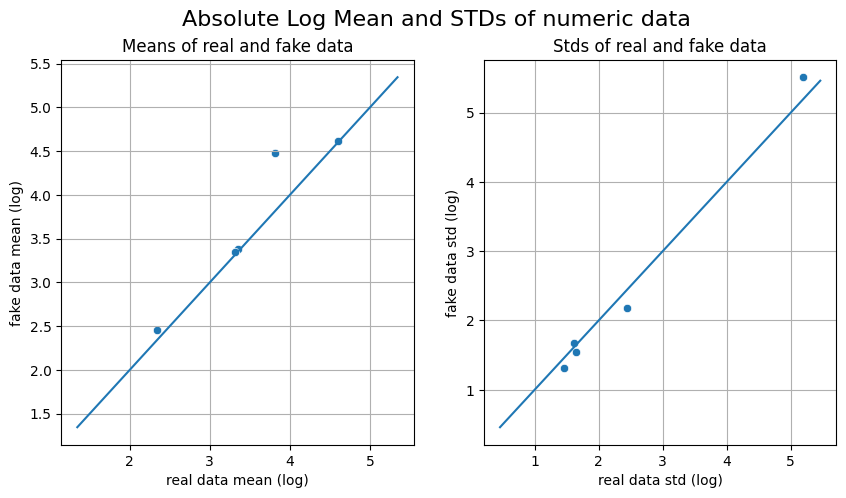

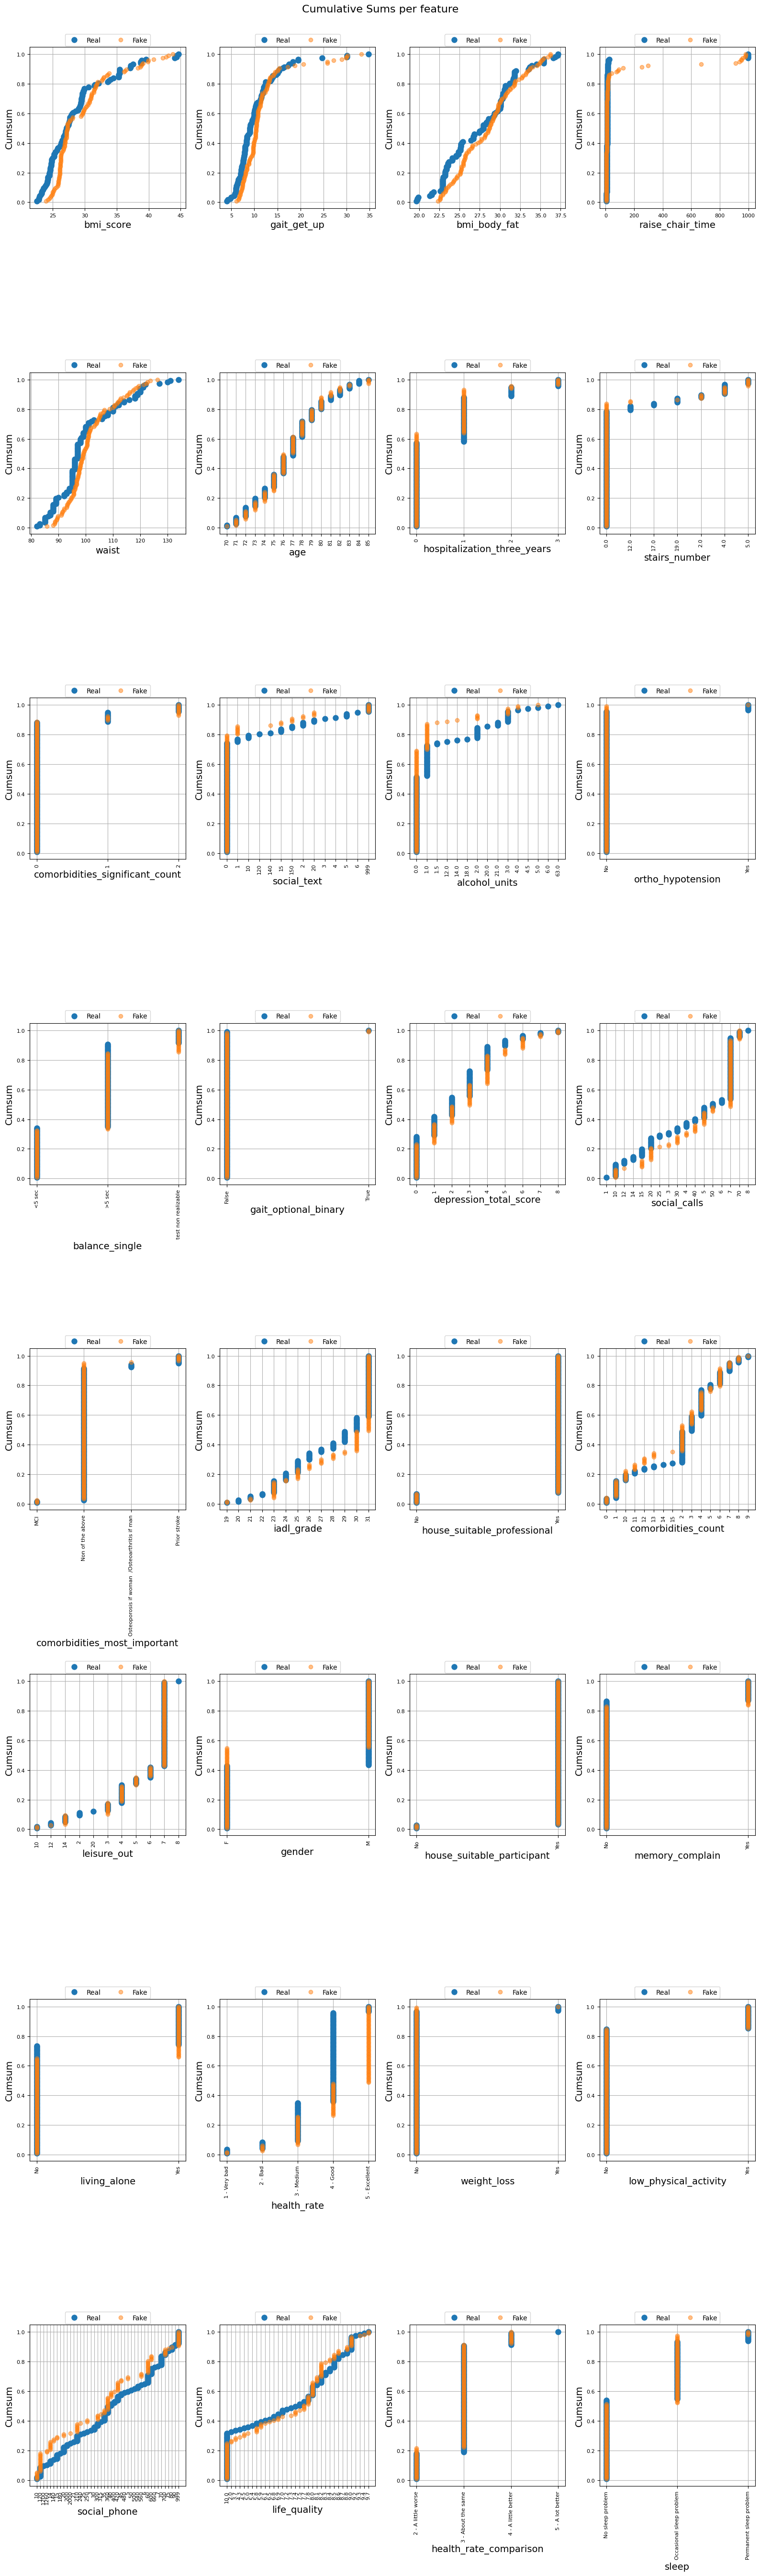

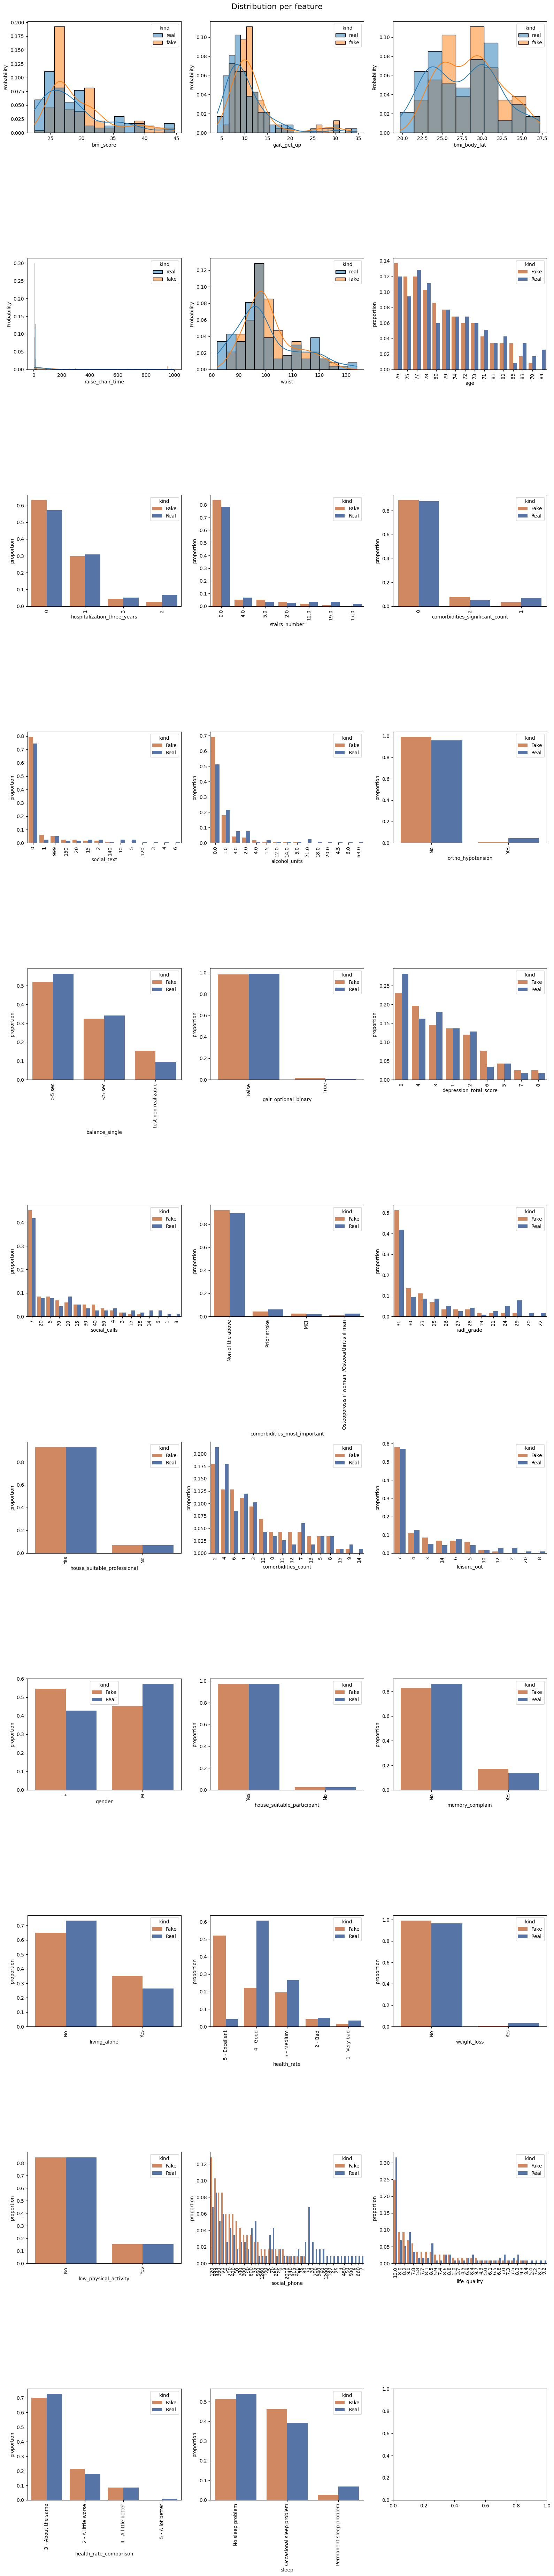

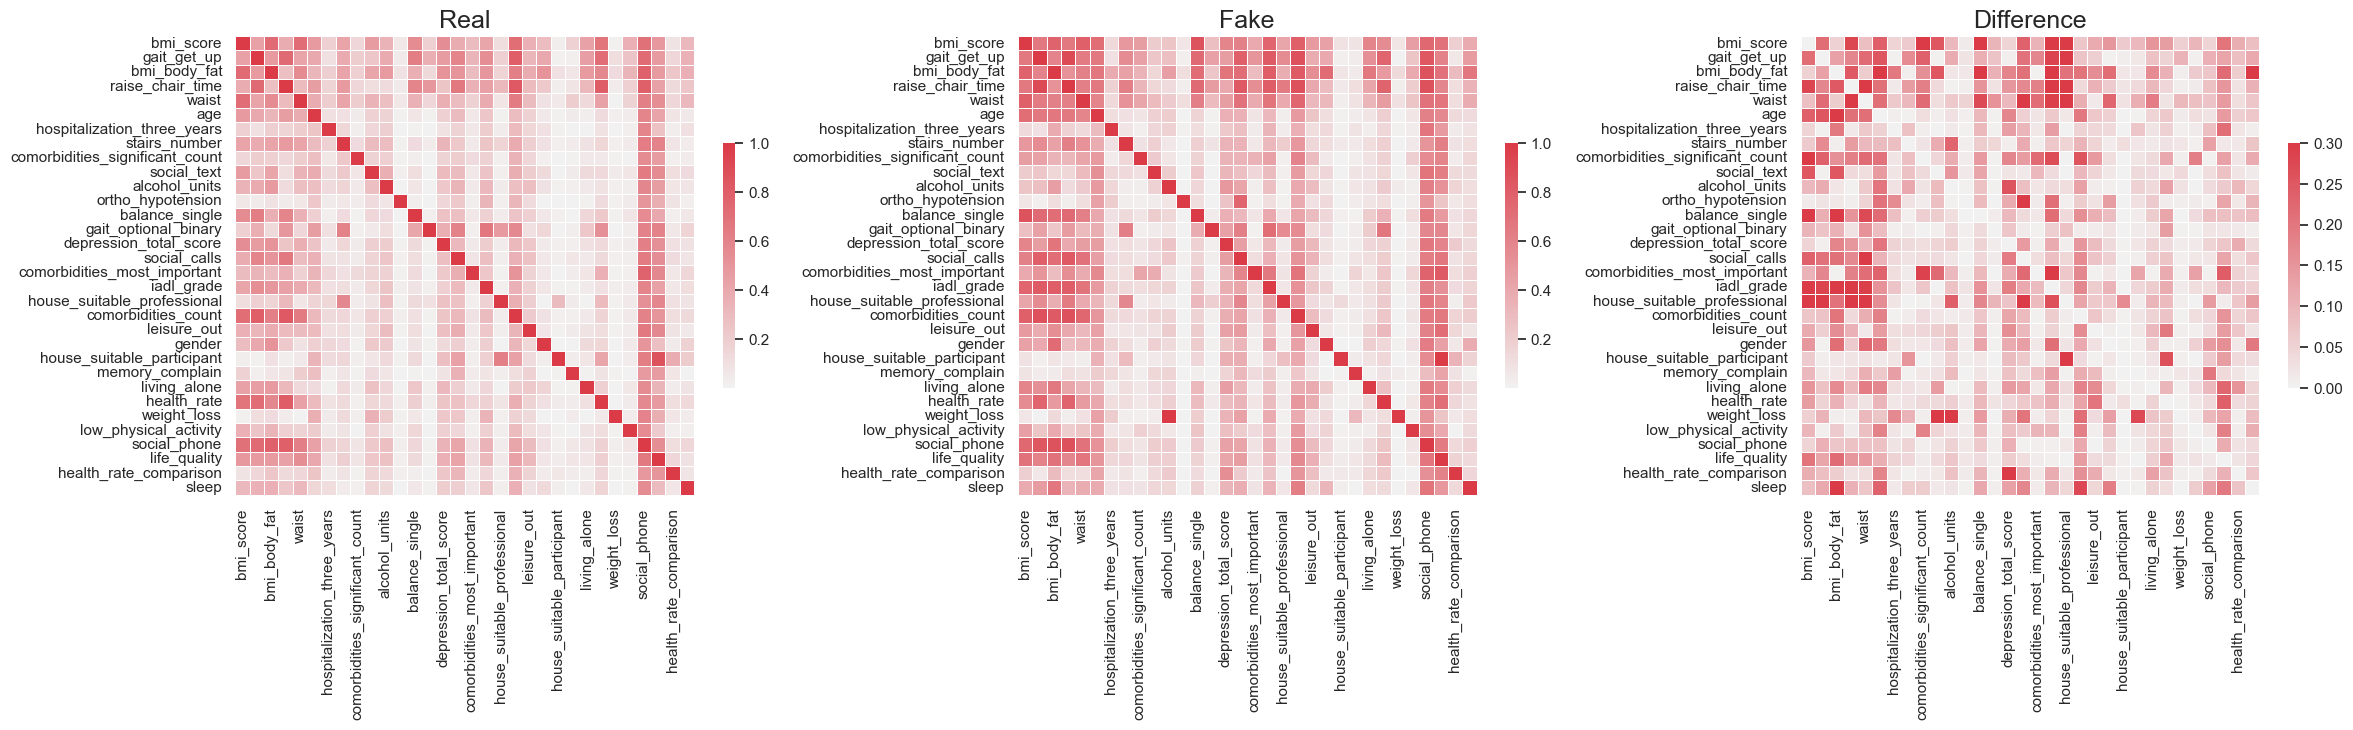

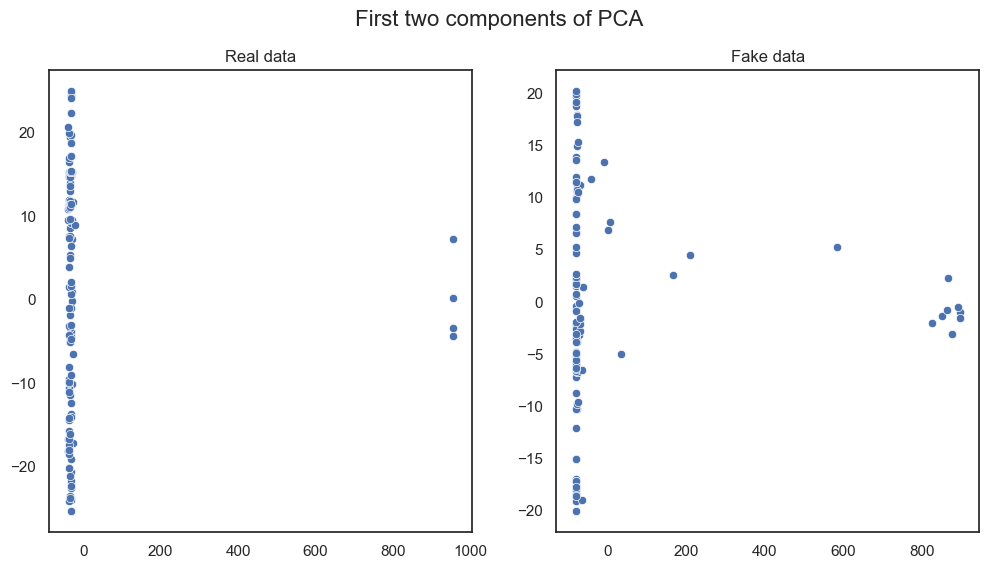

In [6]:

warnings.filterwarnings('ignore', category=UserWarning)

# Create a sample of the original data to match the size of the original data
n_samples = df.shape[0]
sampled_synthetic_data = final_synthetic_data.sample(n=n_samples, random_state=42)

# Create a temporary copy to avoid chained assignment warnings
df_eval = df.copy()
sampled_synthetic_data_eval = sampled_synthetic_data.copy()

# Correct the numerical_cols list to exclude 'time_delta_days' 
numerical_cols = [
    'bmi_score', 'gait_get_up', 'bmi_body_fat', 'raise_chair_time', 'waist'
]
categorical_cols = [
    'age', 'hospitalization_three_years', 'stairs_number', 'comorbidities_significant_count',
    'social_text', 'alcohol_units', 'ortho_hypotension', 'balance_single',
    'gait_optional_binary', 'depression_total_score', 'social_calls',
    'comorbidities_most_important', 'iadl_grade', 'house_suitable_professional',
    'comorbidities_count', 'leisure_out', 'gender', 'house_suitable_participant',
    'memory_complain', 'living_alone', 'health_rate', 'weight_loss',
    'low_physical_activity', 'social_phone', 'life_quality',
    'health_rate_comparison', 'sleep'
]
columns_to_exclude = ['part_id', 'q_date', 'clinical_visit']

# Define the final lists of columns for evaluation
numerical_cols_for_eval = [c for c in numerical_cols if c in df_eval.columns]
categorical_cols_for_eval = [c for c in categorical_cols if c in df_eval.columns]
final_eval_cols = numerical_cols_for_eval + categorical_cols_for_eval

# Impute numerical columns using SimpleImputer
imputer_numerical = SimpleImputer(strategy='mean')
df_eval[numerical_cols_for_eval] = imputer_numerical.fit_transform(df_eval[numerical_cols_for_eval])
sampled_synthetic_data_eval[numerical_cols_for_eval] = imputer_numerical.fit_transform(sampled_synthetic_data_eval[numerical_cols_for_eval])

# Manually impute categorical columns using pandas
for col in categorical_cols_for_eval:
    mode_value_df = df_eval[col].mode()[0]
    df_eval[col].fillna(mode_value_df, inplace=True)
    
    mode_value_synth = sampled_synthetic_data_eval[col].mode()[0]
    sampled_synthetic_data_eval[col].fillna(mode_value_synth, inplace=True)

# use the cleaned data for evaluation.
table_evaluator = TableEvaluator(
    df_eval[final_eval_cols],
    sampled_synthetic_data_eval[final_eval_cols],
    cat_cols=categorical_cols_for_eval
)

table_evaluator.visual_evaluation()

# ***5. Merge real and synthetic data***

In [7]:

# --- 1. Define file paths ---
file1 = 'VirtualPatientModels_dfFinal_qDate.csv'  # Replace with your first file path
file2 = 'VirtualPatientModels_timeGANsynthData_Final_Imbalance_Dis.csv'  # Replace with your second file path 
output_file = 'VirtualPatientModels_tGANsynthDatacombined_Final_Imbalance_Dis.csv' # Output file name  

# --- 2. Load DataFrames ---
try:
    df1 = pd.read_csv(file1)
    print(f"'{file1}' loaded successfully.")
    df2 = pd.read_csv(file2)
    print(f"'{file2}' loaded successfully.")
    
    # --- 3. Align Columns and Data Types ---
    if set(df1.columns) != set(df2.columns):
        print("Error: Column names do not match. Cannot proceed with concatenation.")
    else:
        # Reorder df2 to match df1's column order
        df2 = df2[df1.columns]
        print("Columns have been aligned.")
        
        # Unify data types to a common, safe type
        for col in df1.columns:
            if df1[col].dtype != df2[col].dtype:
                print(f"Warning: Dtype mismatch for column '{col}'. Converting to a common type.")
                common_dtype = np.result_type(df1[col].dtype, df2[col].dtype)
                df1[col] = df1[col].astype(common_dtype)
                df2[col] = df2[col].astype(common_dtype)
        
        # --- 4. Concatenate DataFrames ---
        combined_df = pd.concat([df1, df2], ignore_index=True)
        print("\nDataFrames successfully concatenated!")
        print("Combined DataFrame Info:")
        combined_df.info()

        # --- 5. Export to CSV without the index ---
        try:
            combined_df.to_csv(output_file, index=False)
            print(f"\nCombined DataFrame exported to '{output_file}' successfully!")
        except Exception as e:
            print(f"\nError exporting file: {e}")

except FileNotFoundError as e:
    print(f"Error: {e}")

'VirtualPatientModels_dfFinal_qDate.csv' loaded successfully.
'VirtualPatientModels_timeGANsynthData_Final_Imbalance_Dis.csv' loaded successfully.
Columns have been aligned.

DataFrames successfully concatenated!
Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15249 entries, 0 to 15248
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   part_id                          15249 non-null  int64  
 1   clinical_visit                   15249 non-null  int64  
 2   bmi_score                        15249 non-null  float64
 3   gait_get_up                      15249 non-null  float64
 4   bmi_body_fat                     15249 non-null  float64
 5   raise_chair_time                 15249 non-null  float64
 6   waist                            15249 non-null  float64
 7   leisure_out                      15249 non-null  int64  
 8   balance_single              